In [1]:
import os
from pathlib import Path
import numpy as np
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from lib.city_blocks import load_street_graph, remove_deadends, city_blocks
from lib.config import tmp_folder_path
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

%matplotlib inline

In [2]:
def fix_polygon(pol, fixed_pgs):
    if isinstance(pol, MultiPolygon):
        #print('Multipolygon instance')
        for p in pol.geoms:
            clean = p.buffer(0.0)
            if clean.geom_type == 'Polygon':
                if clean.is_valid:
                    p = clean
                    fixed_pgs.append(p)
            elif clean.geom_type == 'MultiPolygon':
                fix_polygon(clean, fixed_pgs)
    else:
        clean = pol.buffer(0.0)
        if clean.geom_type == 'Polygon':
            if clean.is_valid:
                pol = clean
                fixed_pgs.append(pol)
        elif clean.geom_type == 'MultiPolygon':
            fix_polygon(clean, fixed_pgs)

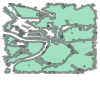

In [3]:
city_gdf = gpd.read_file('geojson/antwerp_grid_blocks.geojson').to_crs({'init': 'epsg:4326'})
city_gdf = city_gdf[city_gdf.is_valid==True]
city_polygon = city_gdf.geometry.unary_union
city_polygon

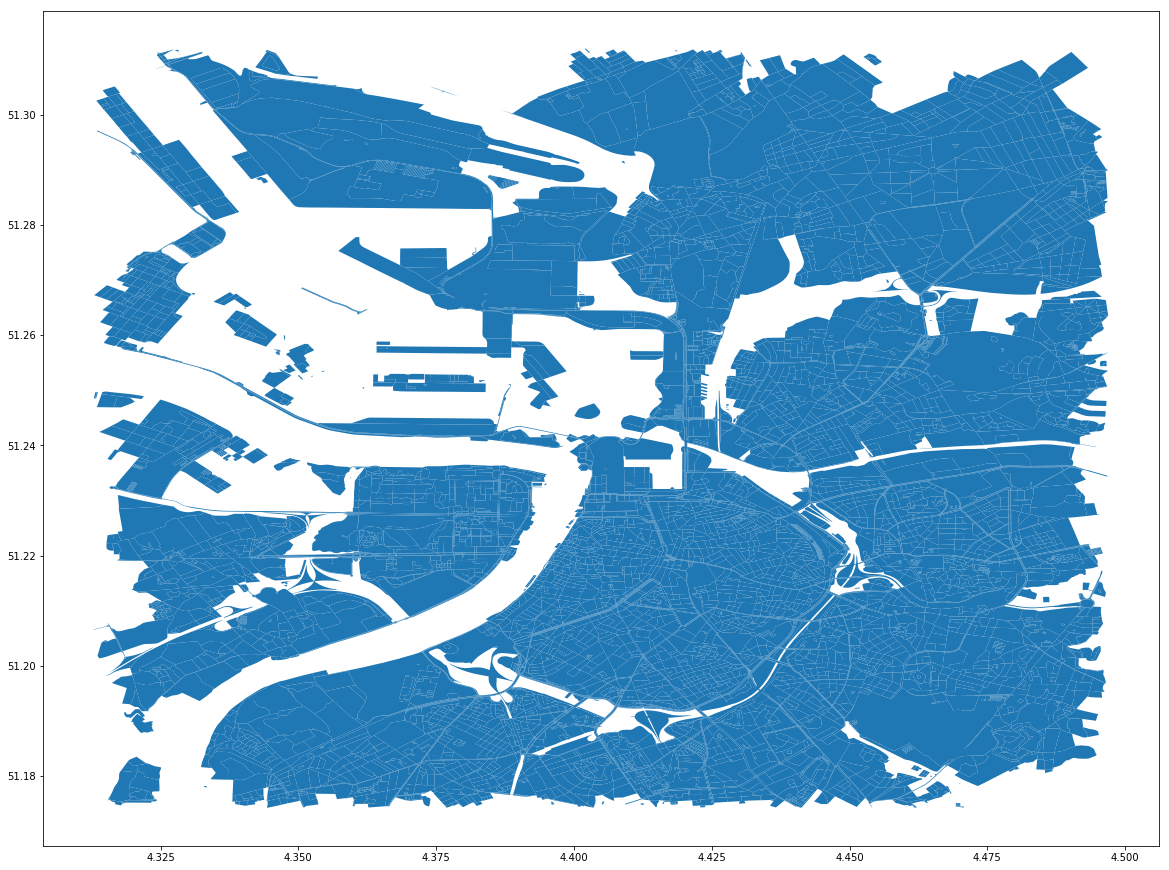

In [4]:
fig, ax = plt.subplots(figsize=(20,20))
city_gdf.plot(ax=ax)

In [5]:
city_gdf.head()

id                                           geometry
0  0  POLYGON ((4.4202885 51.2071573, 4.420148 51.20...
1  1  POLYGON ((4.4447741 51.2298219, 4.4448962 51.2...
2  2  POLYGON ((4.4040164 51.2174279, 4.4039783 51.2...
3  3  POLYGON ((4.4609466 51.2716366, 4.4605986 51.2...
4  4  POLYGON ((4.4637082 51.2727665, 4.4640513 51.2...

In [6]:
def get_overlaps(gdf):
    data_overlaps=gpd.GeoDataFrame(crs=gdf.crs)
    for index, row in tqdm(gdf.iterrows()):
        data_temp1=gdf.loc[gdf.id!=row.id,]
        # check if intersection occured
        overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()
        if len(overlaps)>0:
            for i in overlaps:
                temp_area=gpd.overlay(gdf.loc[gdf.id==i,],gdf.loc[gdf.id==row.id,],how='intersection')
                #temp_area=temp_area.loc[temp_area.geometry.area>=9e-9]
                #if temp_area.shape[0]>0:
                data_overlaps=gpd.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=gdf.crs)
    return data_overlaps
    # get unique of list id
    data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
    data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(str(y)))
    data_overlaps=data_overlaps.drop_duplicates('sorted')
    data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

11273it [13:30, 13.91it/s]


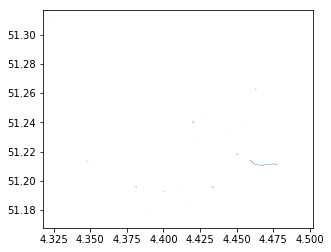

In [7]:
data_overlaps = get_overlaps(city_gdf)
data_overlaps.plot()

In [107]:
def remove_overlaps(overlaps_gdf, gdf):
    for index, row in tqdm(overlaps_gdf.iterrows()):
        mind = gdf[gdf['id']==row['id_1']]
        subsd = gdf[gdf['id']==row['id_2']]
        if mind.geometry.is_valid[0] and subsd.geometry.is_valid[0]:
            gdf.loc[gdf['id']==row['id_1'], 'geometry'] = gpd.overlay(mind, subsd, how='difference').geometry
    return gdf
    # get unique of list id
    #data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
    #data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
    #data_overlaps=data_overlaps.drop_duplicates('sorted')
    #data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

In [9]:
#city_gdf.loc[city_gdf['id']==data_overlaps.loc[0]['id_1'], 'geometry'] = gpd.overlay(city_gdf[city_gdf['id']==data_overlaps.loc[0]['id_1']],city_gdf[city_gdf['id']==data_overlaps.loc[0]['id_2']],how='difference').geometry

In [ ]:
city_gdf_no_overlaps = remove_overlaps(data_overlaps, city_gdf)

In [12]:
city_gdf_no_overlaps

id                                           geometry
0          0  POLYGON ((4.4202885 51.2071573, 4.420148 51.20...
1          1  POLYGON ((4.4447741 51.2298219, 4.4448962 51.2...
2          2  POLYGON ((4.4040164 51.2174279, 4.4039783 51.2...
3          3  POLYGON ((4.4609466 51.2716366, 4.4605986 51.2...
4          4  POLYGON ((4.4637082 51.2727665, 4.4640513 51.2...
5          5  POLYGON ((4.3423009 51.2228588, 4.3421104 51.2...
6          6  POLYGON ((4.3423009 51.2228588, 4.3421619 51.2...
7          7  POLYGON ((4.3429429 51.2224759, 4.3430786 51.2...
8          8  POLYGON ((4.4954555 51.2068806, 4.4953611 51.2...
9          9  POLYGON ((4.484126 51.2270967, 4.4840903 51.22...
10        10  POLYGON ((4.4493689 51.2510404, 4.4492374 51.2...
11        11  POLYGON ((4.4493689 51.2510404, 4.4492783 51.2...
12        12  POLYGON ((4.3408509 51.2136428, 4.3408703 51.2...
13        13  POLYGON ((4.4928411 51.2089087, 4.493009 51.20...
14        14  POLYGON ((4.4705171 51.225792, 4.4705383 51.22...
15        15  POLYGON ((4.4750519 51.2238278, 4.4749169 51.2...
16        16  POLYGON ((4.4883379 51.2978308, 4.4883779 51.2...
17        17  POLYGON ((4.4236226 51.182594, 4.4236686 51.18...
18        18  POLYGON ((4.4372502 51.2034243, 4.4371744 51.2...
19        19  POLYGON ((4.4592341 51.2544074, 4.4590263 51.2...
20        20  POLYGON ((4.4677447 51.1819, 4.4678119 51.1819...
21        21  POLYGON ((4.4529372 51.2191201, 4.4528965 51.2...
22        22  POLYGON ((4.4841796 51.2642104, 4.4849014 51.2...
23        23  POLYGON ((4.4625826 51.2576869, 4.4624741 51.2...
24        24  POLYGON ((4.4918669 51.2215846, 4.4918847 51.2...
25        25  POLYGON ((4.4495058 51.2570432, 4.450784 51.25...
26        26  POLYGON ((4.4201829 51.2446235, 4.4201188 51.2...
27        27  POLYGON ((4.4201829 51.2446235, 4.4203711 51.2...
28        28  POLYGON ((4.3179063 51.2191709, 4.3181161 51.2...
29        29  POLYGON ((4.3179063 51.2191709, 4.3179066 51.2...
...      ...                                                ...
11243  11243  POLYGON ((4.419768553421013 51.23126152374495,...
11244  11244  POLYGON ((4.419736084507782 51.23124117516618,...
11245  11245  POLYGON ((4.32640754225221 51.30909486781837, ...
11246  11246  POLYGON ((4.326453121916743 51.30906526799718,...
11247  11247  POLYGON ((4.4241065 51.2396433, 4.4233117 51.2...
11248  11248  POLYGON ((4.426641054417766 51.23877834608064,...
11249  11249  POLYGON ((4.442640584868263 51.22899324615895,...
11250  11250  POLYGON ((4.442442522272277 51.22888229985271,...
11251  11251  POLYGON ((4.4646072 51.2525593, 4.4643863 51.2...
11252  11252  POLYGON ((4.3749281 51.2881684, 4.3738475 51.2...
11253  11253  POLYGON ((4.3462855 51.296163, 4.3463055 51.29...
11254  11254  POLYGON ((4.4490391 51.1905512, 4.449024 51.19...
11255  11255  POLYGON ((4.3783117 51.2666978, 4.3782984 51.2...
11256  11256  POLYGON ((4.4277726 51.1936041, 4.4278341 51.1...
11257  11257  POLYGON ((4.428763702338055 51.19269597135517,...
11258  11258  POLYGON ((4.429498018008899 51.19202313155908,...
11259  11259  POLYGON ((4.436896669857853 51.20098966865843,...
11260  11260  POLYGON ((4.437242773475271 51.20088387128886,...
11261  11261  POLYGON ((4.438279185266136 51.20318987303323,...
11262  11262  POLYGON ((4.438699860823196 51.20315971018839,...
11263  11263  POLYGON ((4.4406739 51.208635, 4.4407771 51.20...
11264  11264  POLYGON ((4.44260392826868 51.20805971709207, ...
11265  11265  POLYGON ((4.443001919786273 51.20806331528822,...
11266  11266  POLYGON ((4.443211668697717 51.20828571647712,...
11267  11267  POLYGON ((4.448231685573838 51.21454049787128,...
11268  11268  POLYGON ((4.448749410944202 51.21429022757638,...
11269  11269  POLYGON ((4.447322476076145 51.21576436476958,...
11270  11270  POLYGON ((4.447342611644457 51.21595321128901,...
11271  11271  POLYGON ((4.447657540390152 51.21597156479347,...
11272  11272  POLYGON ((4.450823390446812 51.21724659162534,...

[11273 rows x 2 columns]

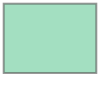

In [13]:
from shapely.ops import cascaded_union
bbox_gdf = gpd.GeoDataFrame(columns=['geometry'], data=gpd.GeoSeries(cascaded_union(gpd.read_file('geojson/grid.json').to_crs({'init': 'epsg:4326'}).geometry)))
bbox_polygon = bbox_gdf.geometry[0]
bbox_polygon

#bbox_gdf = gpd.read_file('geojson/grid.json').to_crs({'init': 'epsg:4326'})
#bbox_polygon = bbox_gdf.geometry.unary_union
#bbox_polygon.plot(edgecolor='gray')

In [14]:
#gdf = ox.gdf_from_place(place_name)
#buildings = ox.create_footprints_gdf(bbox_polygon, retain_invalid=True)
landuse = ox.create_footprints_gdf(bbox_polygon, footprint_type='landuse')
street_graph = ox.graph_from_polygon(bbox_polygon, simplify=False)
nodes, edges = ox.graph_to_gdfs(street_graph)

In [15]:
city_bck_st_gdf = city_gdf_no_overlaps[['geometry']].append(edges[['geometry']], ignore_index=True)
city_bck_st_gdf = city_bck_st_gdf.reset_index()
city_bck_st_gdf = city_bck_st_gdf.rename(index=str, columns={"index": "id"})

In [16]:
city_bck_st_gdf.describe()

id
count  171969.000000
mean    85984.000000
std     49643.318558
min         0.000000
25%     42992.000000
50%     85984.000000
75%    128976.000000
max    171968.000000

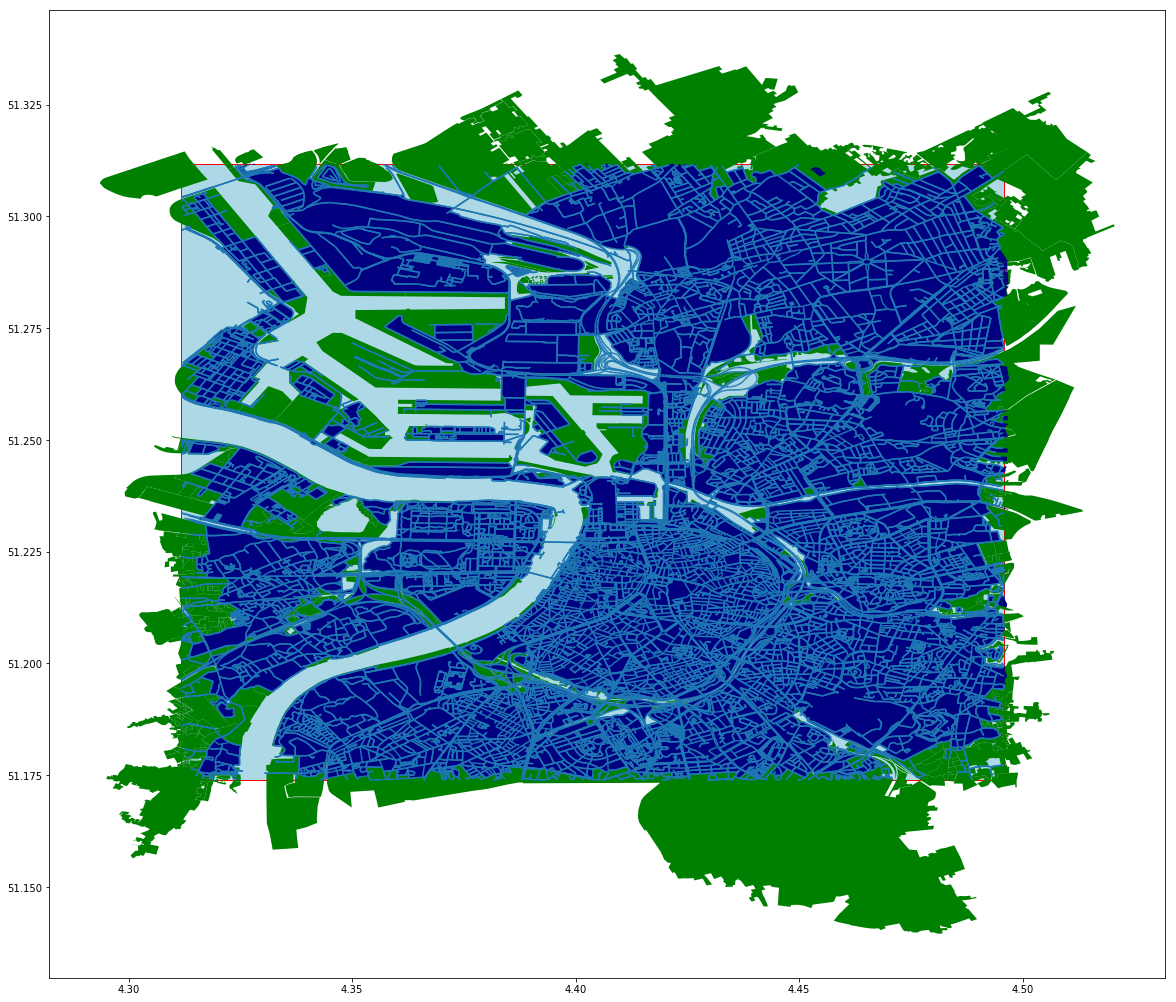

In [17]:
fig0, ax0 = plt.subplots(figsize=(20,20))
bbox_gdf.plot(ax=ax0, facecolor='#add8e6', edgecolor='red')
#edges.plot(ax=ax0, linewidth=1, edgecolor='#BC8F8F')
#area.plot(ax=ax0, facecolor='#000080')
landuse.plot(ax=ax0, facecolor='#008000')
city_bck_st_gdf.plot(ax=ax0, facecolor='#000080')

In [18]:
diff_city_gdf = gpd.overlay(landuse.to_crs({'init': 'epsg:4326'}), city_gdf_no_overlaps.to_crs({'init': 'epsg:4326'}), how='difference')
bbox_city_gdf = gpd.overlay(diff_city_gdf, bbox_gdf, how='intersection')[['geometry']]
bbox_city_gdf = bbox_city_gdf.reset_index()
bbox_city_gdf = bbox_city_gdf.rename(index=str, columns={"index": "id"})

/opt/conda/lib/python3.7/site-packages/geopandas/base.py:35: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and None
  right.crs))


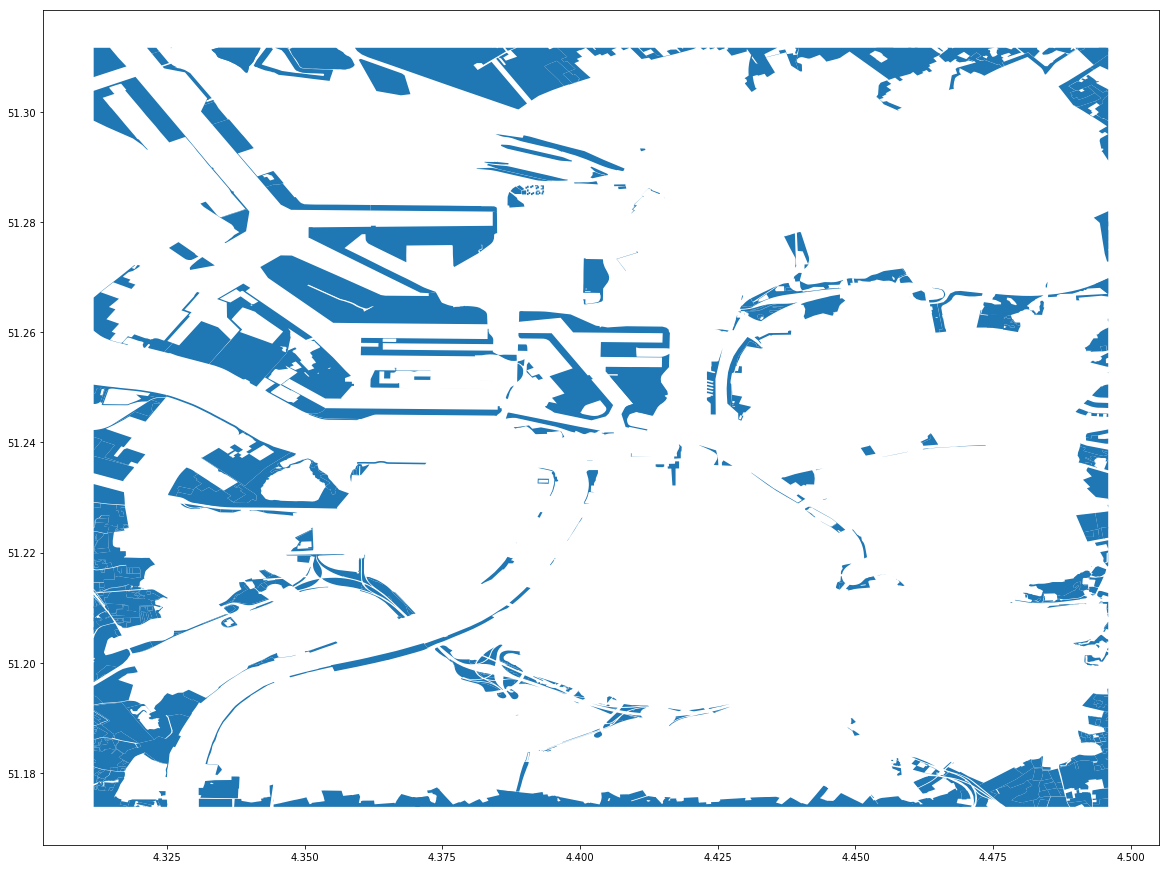

In [19]:
fig2, ax2 = plt.subplots(figsize=(20,20))
bbox_city_gdf.plot(ax=ax2)

In [20]:
bbox_city_overlaps = get_overlaps(bbox_city_gdf)
#bbox_city_overlaps['sorted']=bbox_city_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
#bbox_city_overlaps['sorted']=bbox_city_overlaps.sorted.apply(lambda y: ''.join(str(y)))
#bbox_city_overlaps=bbox_city_overlaps.drop_duplicates('sorted')
#bbox_city_overlaps=bbox_city_overlaps.reset_index()[['id_1','id_2','geometry']]

In [21]:
bbox_city_no_overlaps = remove_overlaps(bbox_city_overlaps, bbox_city_gdf)

84it [00:01, 76.97it/s]


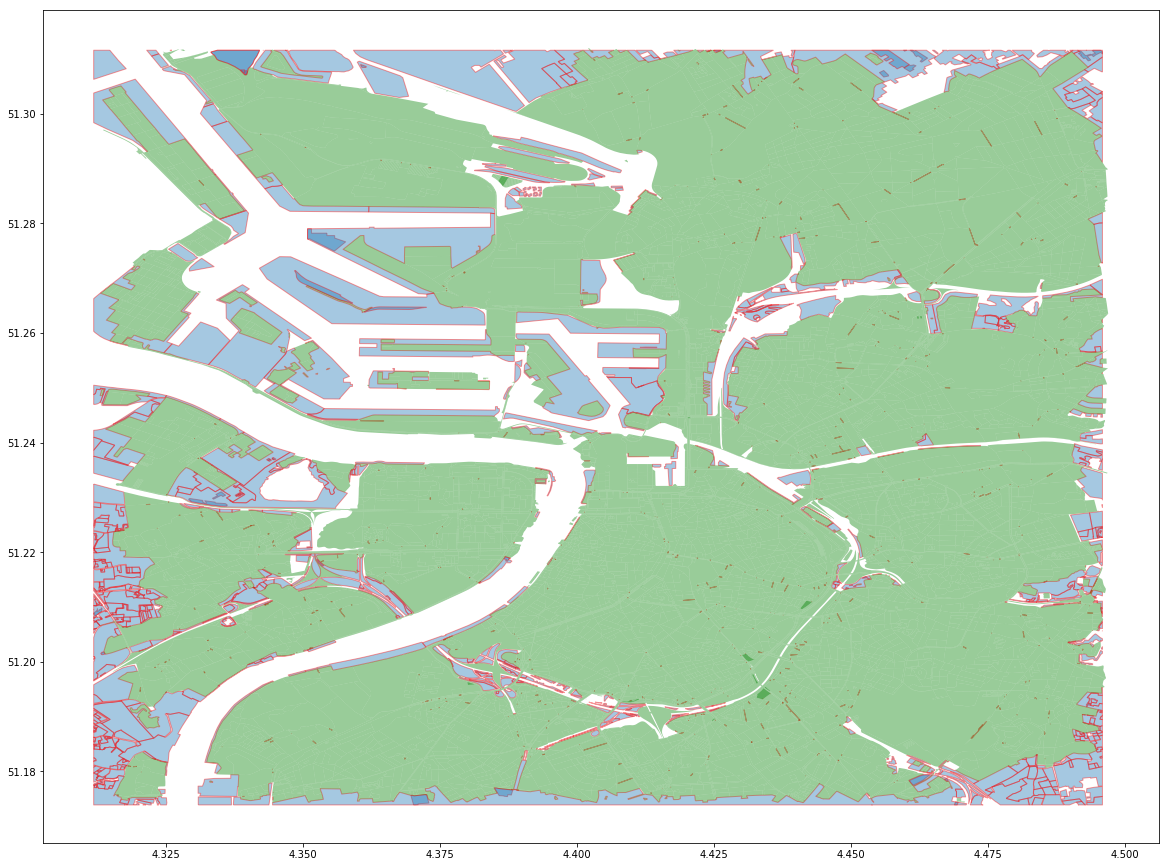

In [41]:
#new_bbox_city_gdf = gpd.overlay(bbox_city_gdf[['geometry']], bbox_city_overlaps[['geometry']], how='difference')
#new_bbox_city_gdf = gpd.overlay(new_bbox_city_gdf[['geometry']], bbox_city_overlaps[['geometry']], how='union')
fig4, ax4 = plt.subplots(figsize=(20,20))
bbox_city_no_overlaps.plot(ax=ax4, alpha=0.4, edgecolor='red')
#bbox_city_overlaps.plot(ax=ax4, alpha=0.4, color='gray')
city_gdf_no_overlaps.plot(ax=ax4, alpha=0.4, color='green')
#bbox_city_no_overlaps.append(city_gdf_no_overlaps, ignore_index=True).plot(ax=ax4, alpha=0.4, color='green')

In [42]:
bbox_city_no_overlaps[bbox_city_no_overlaps.is_valid==False]

Empty GeoDataFrame
Columns: [id, geometry]
Index: []

In [60]:
blocks_gdf = bbox_city_no_overlaps[['geometry']].append(city_gdf_no_overlaps[['geometry']], ignore_index=True)
blocks_gdf = blocks_gdf.reset_index()
blocks_gdf = blocks_gdf.rename(index=str, columns={"index": "id"})
blocks_gdf = blocks_gdf[blocks_gdf.is_valid==True]
blocks_gdf.shape

(12136, 2)

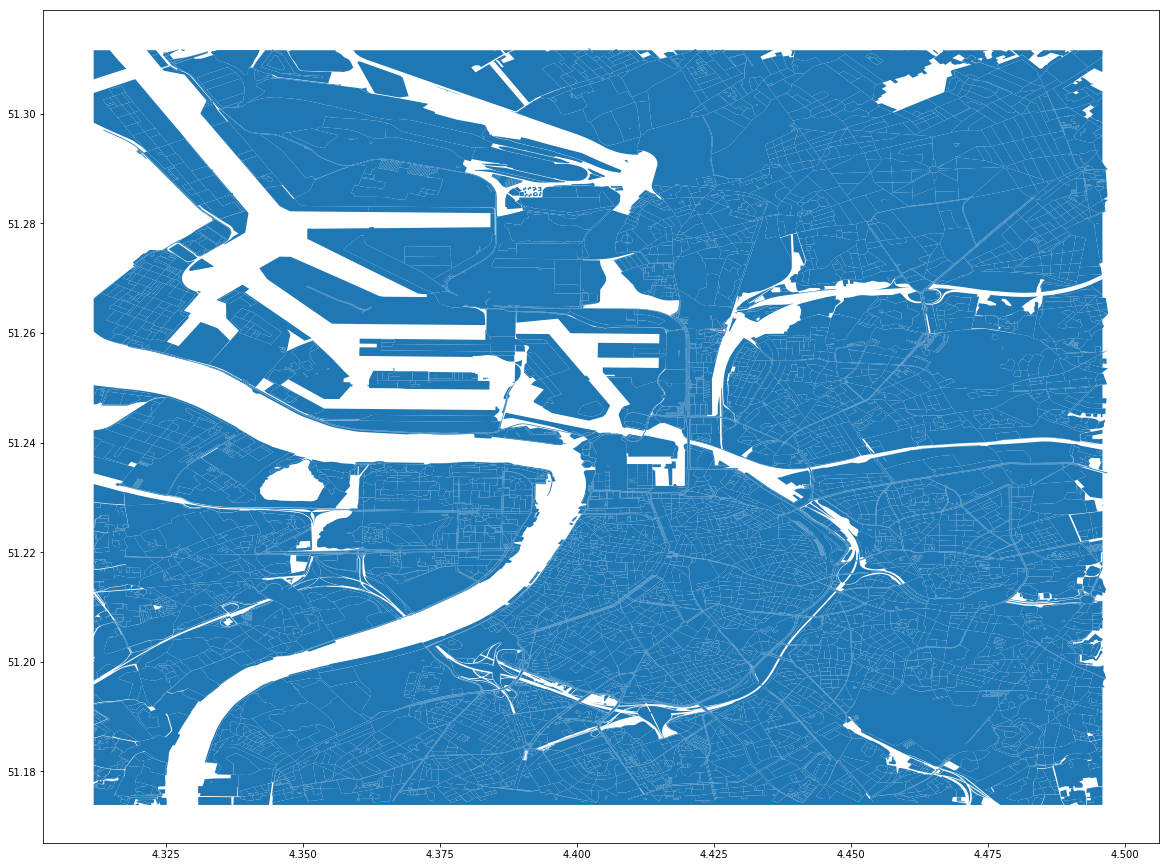

In [61]:
fig3, ax3 = plt.subplots(figsize=(20,20))
blocks_gdf.plot(ax=ax3)

In [62]:
assert blocks_gdf[blocks_gdf.is_valid == False].shape[0] == 0

In [63]:
streets_gdf = edges[['geometry']]
streets_gdf = streets_gdf.reset_index()
streets_gdf = streets_gdf.rename(index=str, columns={"index": "id"})

In [112]:
blocks_gdf[blocks_gdf.is_valid==True].shape

(12044, 2)

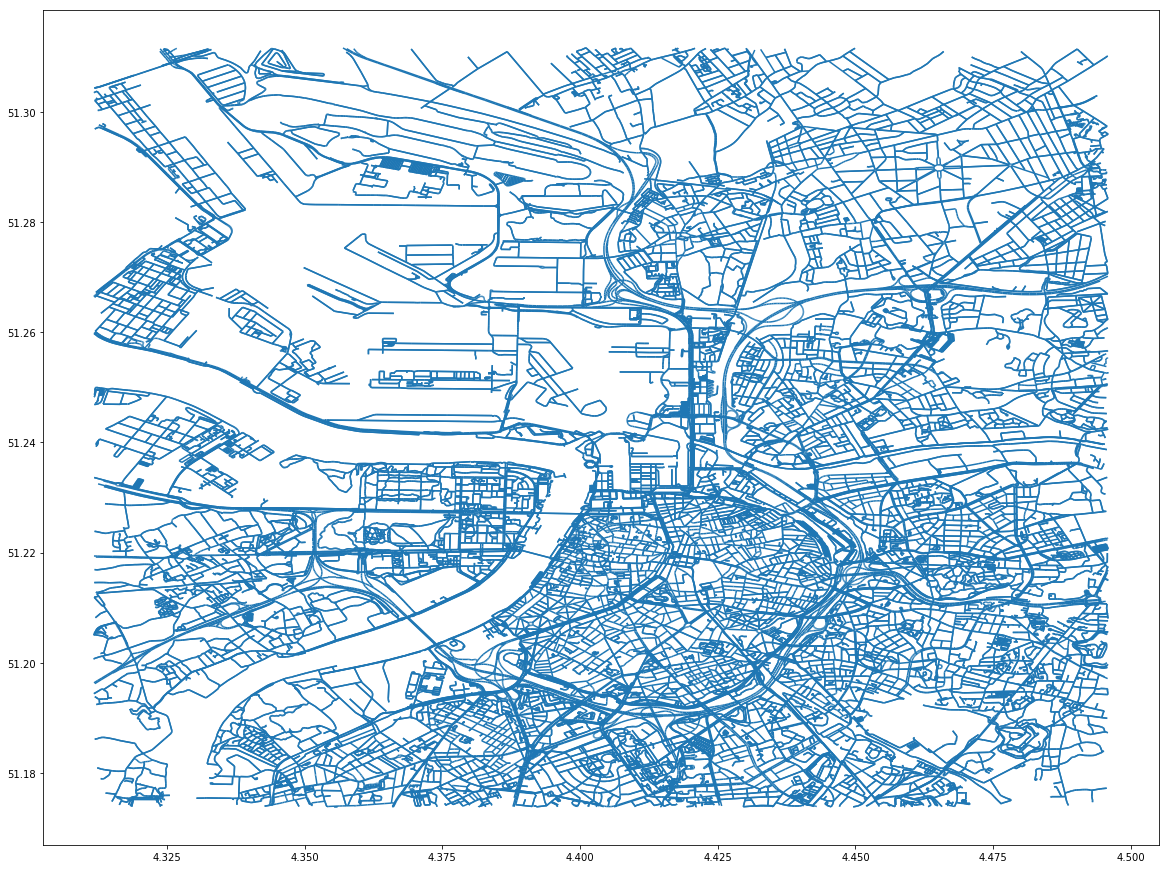

In [65]:
fig1, ax1 = plt.subplots(figsize=(20,20))
streets_gdf.plot(ax=ax1)

In [ ]:
blocks_overlaps_gdf = get_overlaps(blocks_gdf)

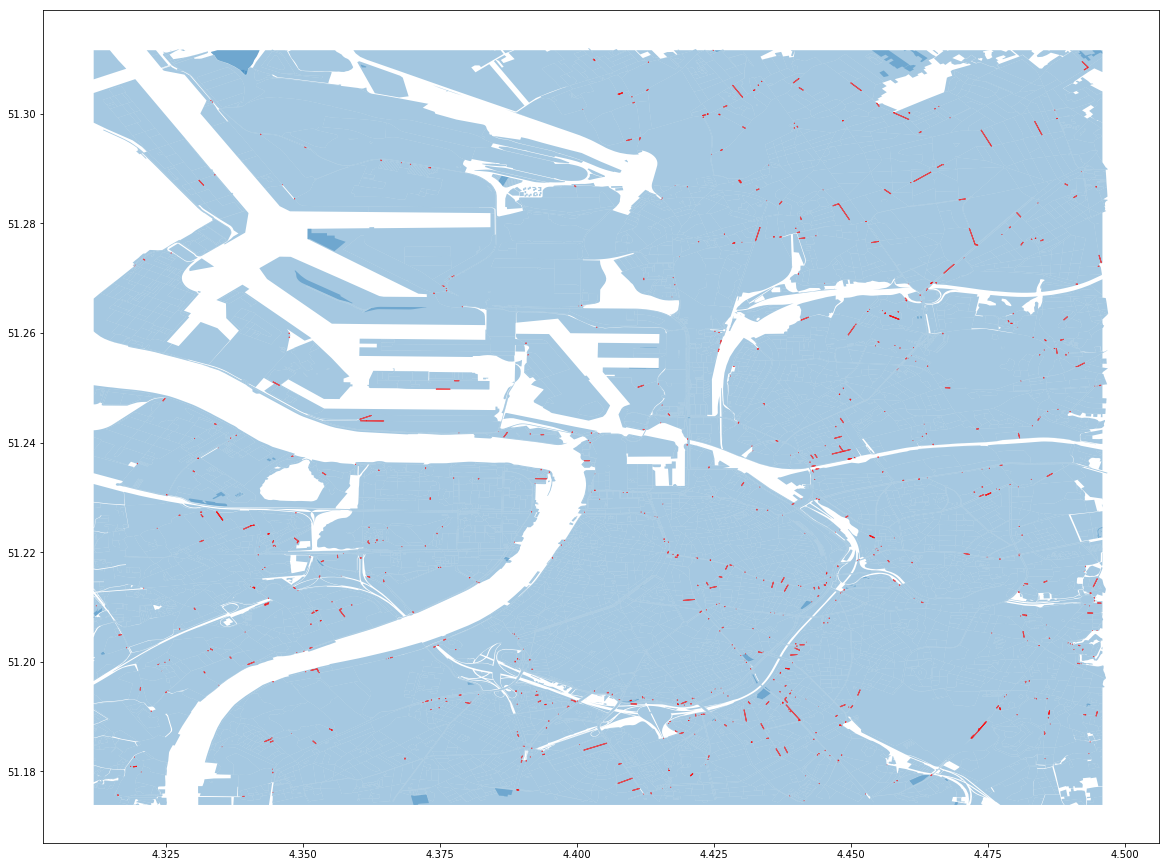

In [67]:
fig4, ax4 = plt.subplots(figsize=(20,20))
blocks_gdf.plot(ax=ax4, alpha=0.4)
blocks_overlaps_gdf.plot(ax=ax4, alpha=0.4, edgecolor='red')

In [104]:
#blocks_no_overlaps_gdf = remove_overlaps(blocks_overlaps_gdf, blocks_gdf)
blocks_gdf[blocks_gdf['id']==6].geometry.is_valid[0]

False

In [ ]:
blocks_no_overlaps_gdf = remove_overlaps(blocks_overlaps_gdf, blocks_gdf)

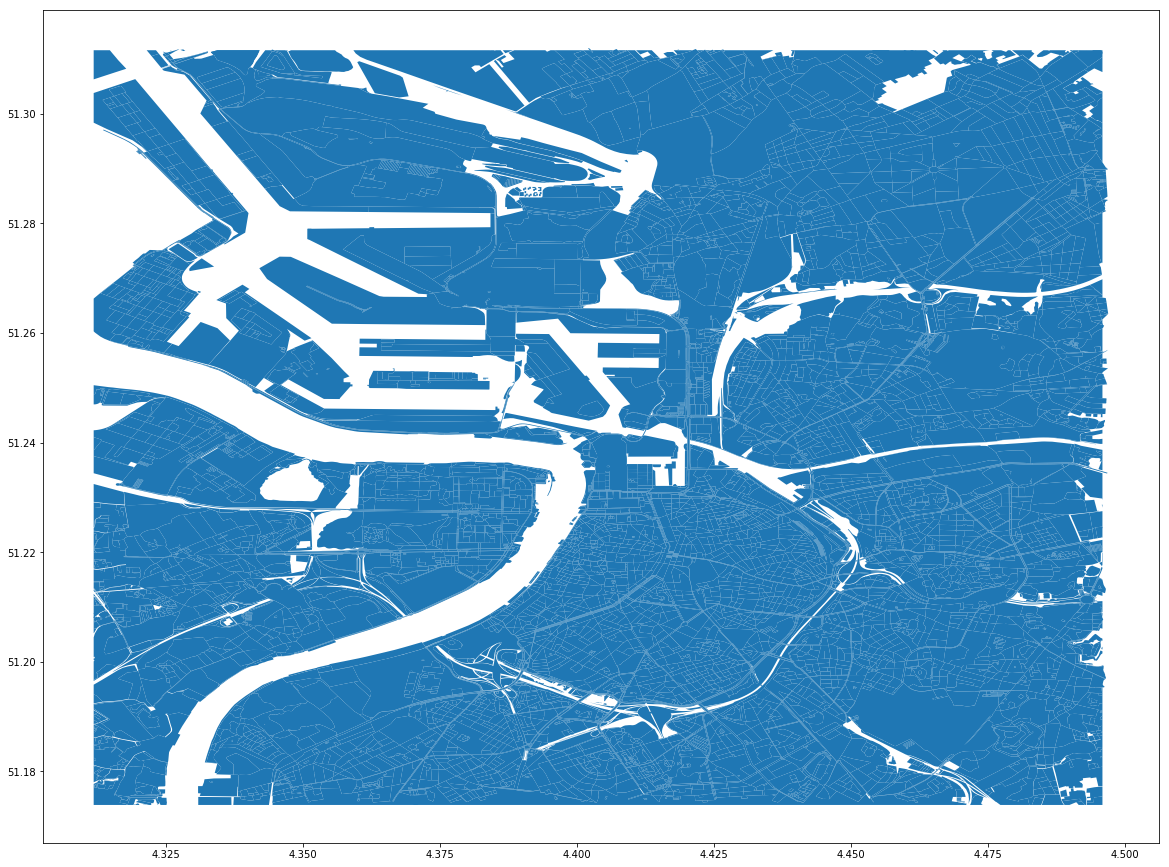

In [119]:
fig4, ax4 = plt.subplots(figsize=(20,20))
blocks_no_overlaps_gdf.plot(ax=ax4)

In [117]:
blocks_no_overlaps_gdf = blocks_no_overlaps_gdf[blocks_no_overlaps_gdf.is_valid==True]

In [ ]:
_overlaps_df = get_overlaps(blocks_no_overlaps_gdf)

(50, 3)

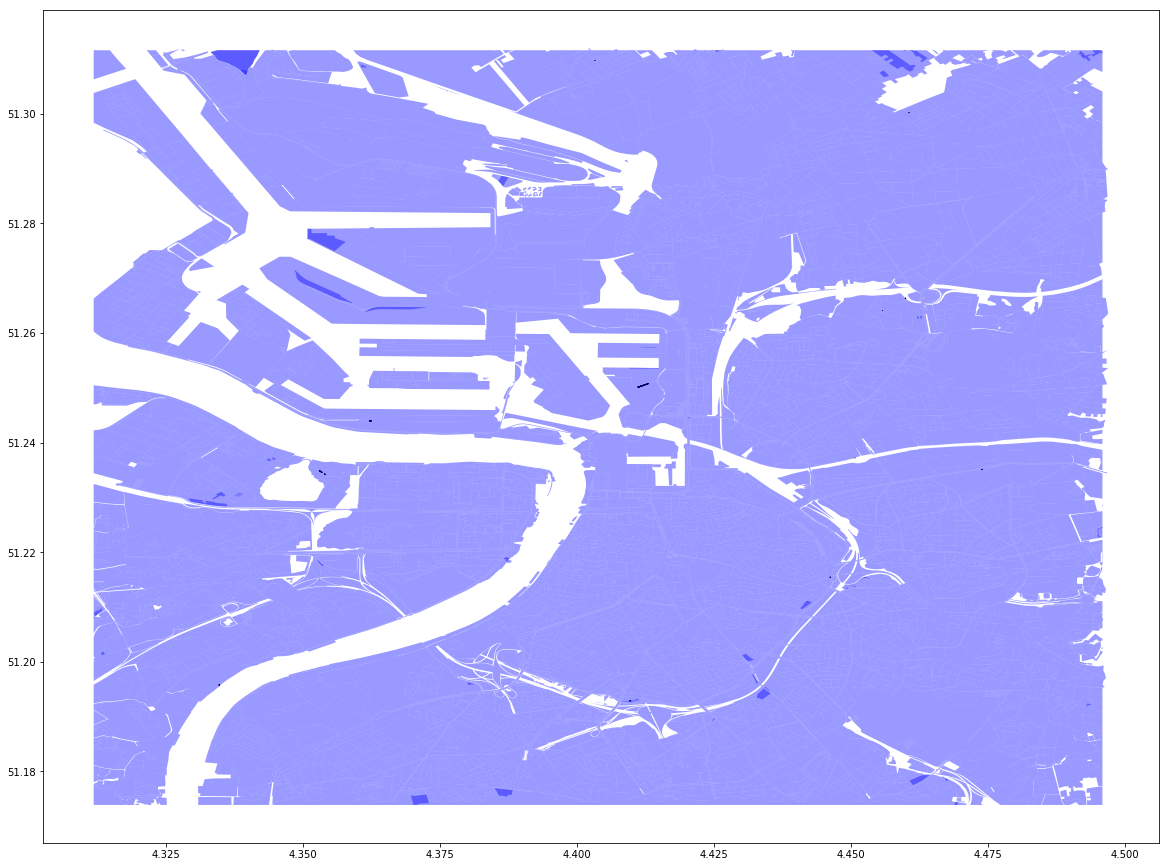

In [131]:
fig5, ax5 = plt.subplots(figsize=(20,20))
_overlaps_df.plot(ax=ax5, edgecolor='k')
blocks_no_overlaps_gdf.plot(ax=ax5, alpha=0.4, color='blue')
_overlaps_df.shape

In [126]:
blocks_no_overlaps_gdf = gpd.overlay(blocks_no_overlaps_gdf, _overlaps_df, how='difference')

In [128]:
assert len(blocks_no_overlaps_gdf[blocks_no_overlaps_gdf.is_valid==False])==0

## Save areas as GeoJson

In [129]:
filename = 'antwerp_sq_grid_blocks'
geofile = Path(tmp_folder_path, filename).with_suffix('.geojson')

with open(geofile, 'w+') as af: 
    af.write(blocks_no_overlaps_gdf.to_json())